In [14]:
# evaluate RF

In [15]:
import pandas as pd
from graphviz import Digraph
from copy import deepcopy

import networkx as nx

In [16]:
def create_graph_from_dict(tree_dict, output_file=''):
    # draw a tree from child parent dictionary
    graph = Digraph('G', format='png')
    
    # node attributes
    graph.attr('node', 
               shape='circle',
               fixedsize='true', 
               width='0.35', 
               height='0.35',
               fontsize='8.75'
               )
    
    # edge attributes
    graph.attr('edge', 
               arrowsize='0.4',
               splines='false'
               )
    
    # convert dictionary, mapping child to parent, to edges
    edges = [(parent, child) for child, parent in tree_dict.items()]

    # add the edges to the graph
    for parent, child in edges:
        graph.edge(parent, child)

    return graph

def create_undirected_graph_from_dict(tree_dict):
    # add nodes/edges to graph, networkx object
    graph = nx.Graph(tree_dict)
    
    # get layout of nodes
    pos = nx.spring_layout(graph)
    
    nx.draw(graph, 
            pos, 
            with_labels=True, 
            node_size=500, 
            node_color='lightgrey', 
            font_family='Arial'
            )
    
    return graph

def create_undirected_graph(graph, pos):    
    # drawing function given graph and layout
    nx.draw(graph, 
            pos, 
            with_labels=True, 
            node_size=500, 
            node_color='lightgrey', 
            font_family='Arial'
            )
    
    return graph

def get_bipartitions(graph):
    internal_edges = get_internal_edges(graph)
    bipartion_set = []

    for edge in internal_edges:
    
        cp_G = deepcopy(graph)
        cp_G.remove_edge(*edge)

        l_bip, r_bip = list(nx.connected_components(cp_G))

        if not len(l_bip) < len(r_bip):

            # stupid, but works
            hold = l_bip
            l_bip = r_bip
            r_bip = hold

        bipartion_set.append(
            f"{''.join(sorted(l_bip))}|{''.join(sorted(r_bip))}"
            )
    
    return bipartion_set

def get_internal_nodes(graph):
    # internal edges have degree > 1
    return [node for node in graph.nodes() if graph.degree(node) > 1]

def get_internal_edges(graph):
    internal_nodes = get_internal_nodes(graph)
    return [(u, v) for (u, v) in graph.edges() \
            if u in internal_nodes and v in internal_nodes]


In [17]:
OUT = '/Users/wuchh/Documents/DETOPT-P/sim_results/simNo_1-s_11-m_100-h_40-cna_0.2-cov_100_subsample_5.detopt.tsv'

GT = '/Users/wuchh/Documents/DETOPT-P/ground-truth/simNo_1-s_11-m_100-h_40-cna_0.2.tree.tsv'

In [18]:
assignments = pd.read_csv(OUT, sep='\t', header=None)
assignments.columns = ['mut','objective','node','CN','node_cn']

In [19]:
node_assignments = assignments.set_index('mut')['node'].to_dict()

In [20]:
ground_truth = pd.read_csv(GT, sep='\t')

In [21]:
ground_truth_assignments = {}

for _, row in ground_truth.iterrows():

    if row['NODE_ID'] == 'ROOT': continue
    else:
        snvs = row['SNV_IDS'].split(',')

        for snv in snvs:
            ground_truth_assignments[snv] = row['NODE_ID'] 

In [22]:
incorrect_assignments = {}

for mut, assignment in node_assignments.items():

    node_mutations = ground_truth[ground_truth['NODE_ID'] == str(assignment)]['SNV_IDS']
    
    if mut not in node_mutations.tolist()[0].split(','):
        print(mut, assignment, ground_truth_assignments[mut])

        incorrect_assignments[mut] = (str(assignment), ground_truth_assignments[mut])

mut21 3 2
mut49 5 4


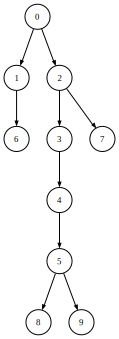

In [23]:
tree_dict = ground_truth.set_index('NODE_ID')['PARENT_ID'].to_dict()
del tree_dict['ROOT']
del tree_dict['0']
graph = create_graph_from_dict(tree_dict, '')

graph

In [24]:
def swap(tree_dict_orginal, a, b):

    tree_dict = deepcopy(tree_dict_orginal)

    assert(a != b)

    # if b is the root
    if not b in tree_dict.keys():
        tree_dict[b] = 'a'
        tree_dict = swap(tree_dict, a, b)
        del tree_dict[a]
        return tree_dict
    elif not a in tree_dict.keys():
        tree_dict[a] = 'a'
        tree_dict = swap(tree_dict, a, b)
        del tree_dict[a]
        return tree_dict

    a_children = []
    b_children = []
    # Go over all the nodes and if it's a parent of one set it to the other
    for k, v in tree_dict.items():
        if v == a:
            a_children.append(k)
        elif v == b:
            b_children.append(k)


    # If one is the parent of the other
    if tree_dict[a] == b:
        tree_dict[a] = tree_dict[b]
        tree_dict[b] = a
        b_children.remove(a)
        for a_child in b_children:
            tree_dict[a_child] = a
        for b_child in a_children:
            tree_dict[b_child] = b
        return tree_dict
    elif tree_dict[b] == a:
        tree_dict[b] = tree_dict[a]
        tree_dict[a] = b

        a_children.remove(b)

        for a_child in b_children:
            tree_dict[a_child] = a
        for b_child in a_children:
            tree_dict[b_child] = b

        return tree_dict





    # Assuming One isn't the parent of the other
    a_parent = tree_dict[a]
    b_parent = tree_dict[b]

    # Swap the parents
    tree_dict[a] = b_parent
    tree_dict[b] = a_parent


    for a_child in b_children:
        tree_dict[a_child] = a
    
    
    for b_child in a_children:
        tree_dict[b_child] = b


    

    return tree_dict



In [25]:
def delete_node(tree_dict, a):

    copy_tree = deepcopy(tree_dict)
    par_a = copy_tree[a]

    for child, parent in copy_tree.items():
        if parent == a:
            copy_tree[child] = par_a

    del copy_tree[a]

    return copy_tree

In [26]:
rf_dists = []
for mut in incorrect_assignments.keys():

    inferred, true = incorrect_assignments[mut]

    print(mut, inferred, true)

    new_tree_dict = swap(tree_dict, inferred, true)
    new_tree_dict = delete_node(new_tree_dict, true)

    original_tree_dict = delete_node(tree_dict, true)

    new = create_undirected_graph_from_dict(new_tree_dict)
    old = create_undirected_graph_from_dict(original_tree_dict)

    new_bip = get_bipartitions(new)
    old_bip = get_bipartitions(old)

    rf_dists.append(robinson_foulds_distance(new_bip, old_bip))

avg_rf = sum(rf_dists) / len(rf_dists)  

NameError: name 'inferred' is not defined

In [ ]:
avg_rf 

1.0